<a href="https://colab.research.google.com/github/isawich/2025_PBO_TI1C/blob/main/Visikom_JB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Praktikum 1

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32) # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)

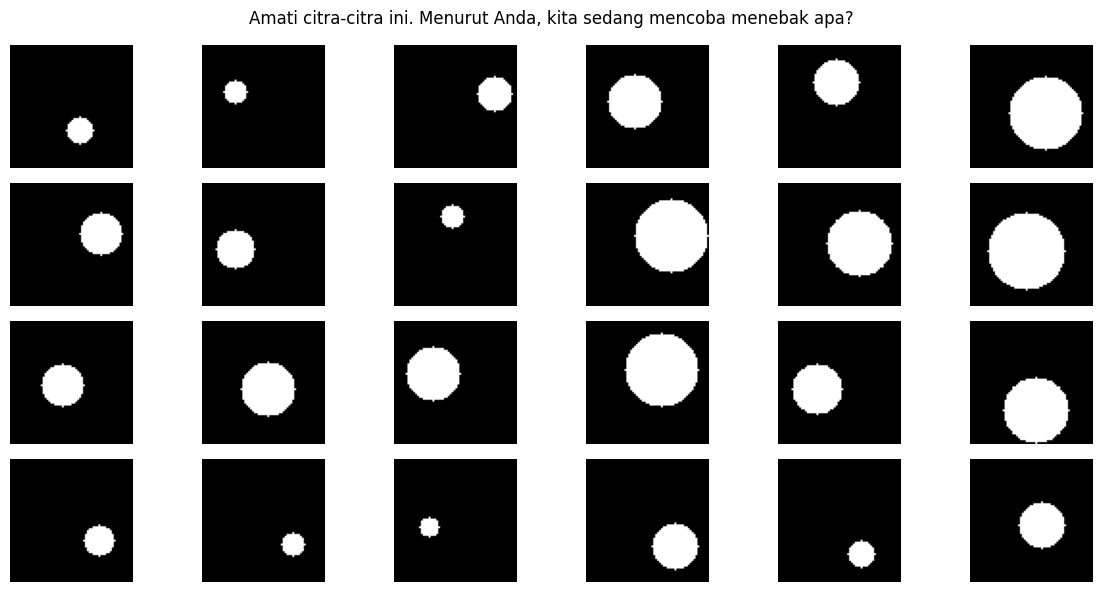

In [39]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

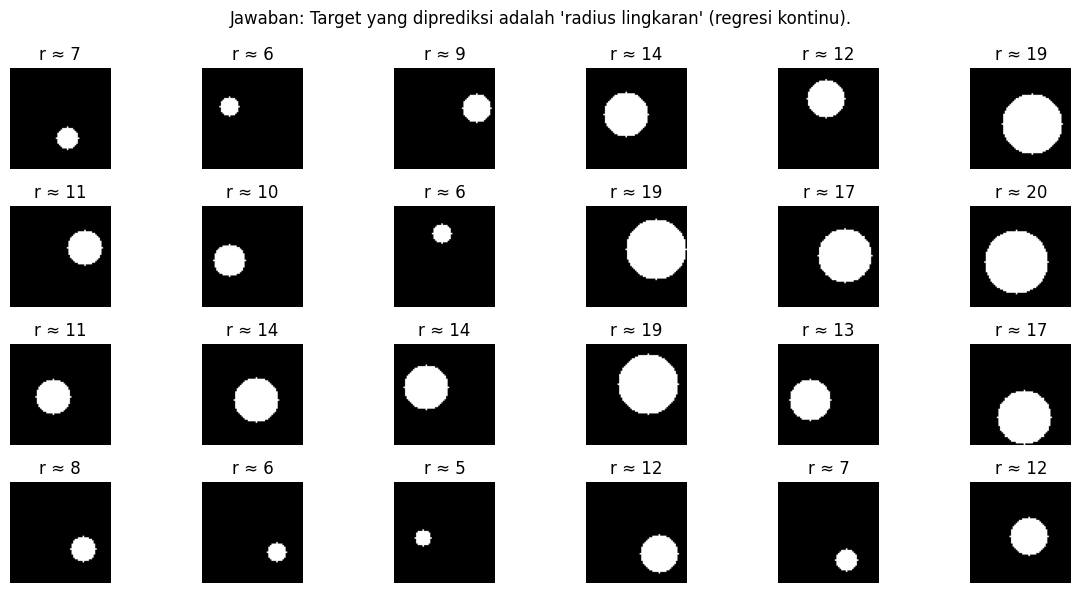

In [40]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

In [41]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(), layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.963 | RMSE=1.159 | R²=0.934


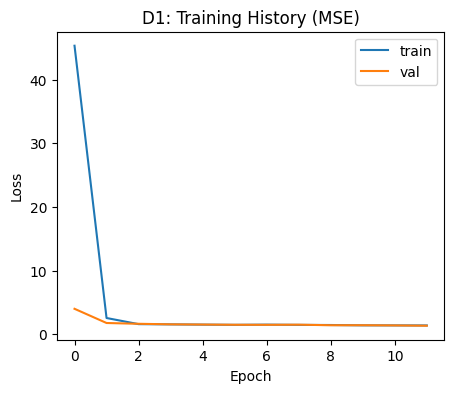

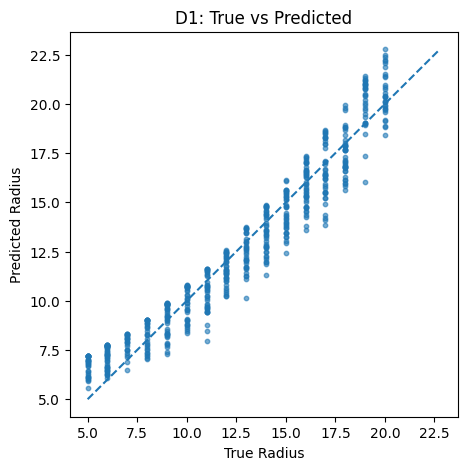

In [42]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


Tantangan Mini (Praktikum 1)

Dataset baru dibuat dengan rentang radius 8.0-28.0

Melatih model dengan rentang radius baru...
Pelatihan selesai.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Hasil Evaluasi (Radius 8-28):
MAE=0.704 | RMSE=0.881 | R²=0.979


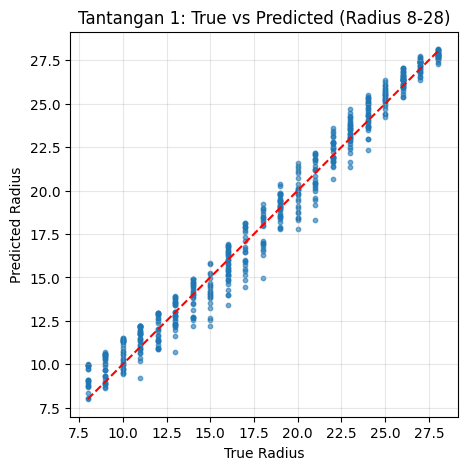

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Modifikasi Generator dengan rentang radius baru
# Ubah min_r dan max_r menjadi 8 dan 28
def make_sample_new_radius(img_size=64, min_r=8, max_r=28): # Diubah
    """Membuat 1 sampel gambar lingkaran dengan rentang radius baru."""
    # Radius acak sesuai rentang baru
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    # Pastikan pusat lingkaran tidak membuat lingkaran terpotong
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)

    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)

    # Buat menjadi 3 channel agar kompatibel dengan model CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r)

# 2. Buat Dataset Baru
N = 3000
# Gunakan generator yang sudah dimodifikasi
samples = [make_sample_new_radius() for _ in range(N)]
X = np.array([s[0] for s in samples])
y = np.array([s[1] for s in samples])

# Bagi dataset
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dataset baru dibuat dengan rentang radius {y.min()}-{y.max()}")

# 3. Bangun, Latih, dan Evaluasi Model (Sama seperti di jobsheet)
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # Output regresi untuk radius
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nMelatih model dengan rentang radius baru...")
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)
print("Pelatihan selesai.")

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

print(f"\nHasil Evaluasi (Radius 8-28):")
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

# Plot True vs Predicted
plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("Tantangan 1: True vs Predicted (Radius 8-28)")
plt.grid(True, alpha=0.3)
plt.show()

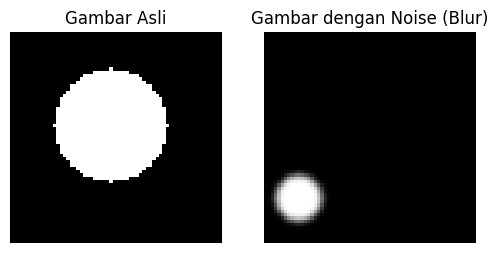


Melatih model dengan data noisy...
Pelatihan selesai.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Hasil Evaluasi (Data Noisy):
MAE=0.910 | RMSE=1.126 | R²=0.943


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Generator Asli (Radius 5-20)
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    return img, float(r)

# 2. Fungsi untuk Menambahkan Noise (Gaussian Blur)
def add_gaussian_blur(image, kernel_size=(5, 5)):
    """Menerapkan Gaussian blur pada gambar."""
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred_image

# 3. Buat Dataset dengan Noise
N = 3000
X_noisy = []
y_noisy = []

for _ in range(N):
    img, r = make_sample()
    # Tambahkan noise ke gambar
    noisy_img = add_gaussian_blur(img)

    # Normalisasi dan ubah ke 3 channel
    noisy_img_normalized = (noisy_img / 255.0).astype(np.float32)
    img3 = np.stack([noisy_img_normalized] * 3, axis=-1)

    X_noisy.append(img3)
    y_noisy.append(r)

X_noisy = np.array(X_noisy)
y_noisy = np.array(y_noisy)

# Tampilkan contoh gambar dengan noise
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(X[0].squeeze(), cmap='gray')
plt.title("Gambar Asli")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_noisy[0].squeeze(), cmap='gray')
plt.title("Gambar dengan Noise (Blur)")
plt.axis('off')
plt.show()

# Bagi dataset
Xtr, Xte, ytr, yte = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=42)

# 4. Bangun, Latih, dan Evaluasi Model
model_noisy = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model_noisy.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nMelatih model dengan data noisy...")
history_noisy = model_noisy.fit(Xtr, ytr, validation_data=(Xte, yte),
                                epochs=12, batch_size=64, verbose=0)
print("Pelatihan selesai.")

# Evaluasi
y_pred_noisy = model_noisy.predict(Xte).ravel()
mae_noisy = mean_absolute_error(yte, y_pred_noisy)
rmse_noisy = float(np.sqrt(np.mean((yte - y_pred_noisy)**2)))
r2_noisy = r2_score(yte, y_pred_noisy)

print(f"\nHasil Evaluasi (Data Noisy):")
print(f"MAE={mae_noisy:.3f} | RMSE={rmse_noisy:.3f} | R²={r2_noisy:.3f}")

Bentuk data X: (2400, 64, 64, 3), Bentuk data y: (2400, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)


Melatih model multi-output...
Pelatihan selesai.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

MAE Keseluruhan: 2.958

MAE per Variabel:
Radius (r): 0.915
Center X (cx): 3.859
Center Y (cy): 4.098


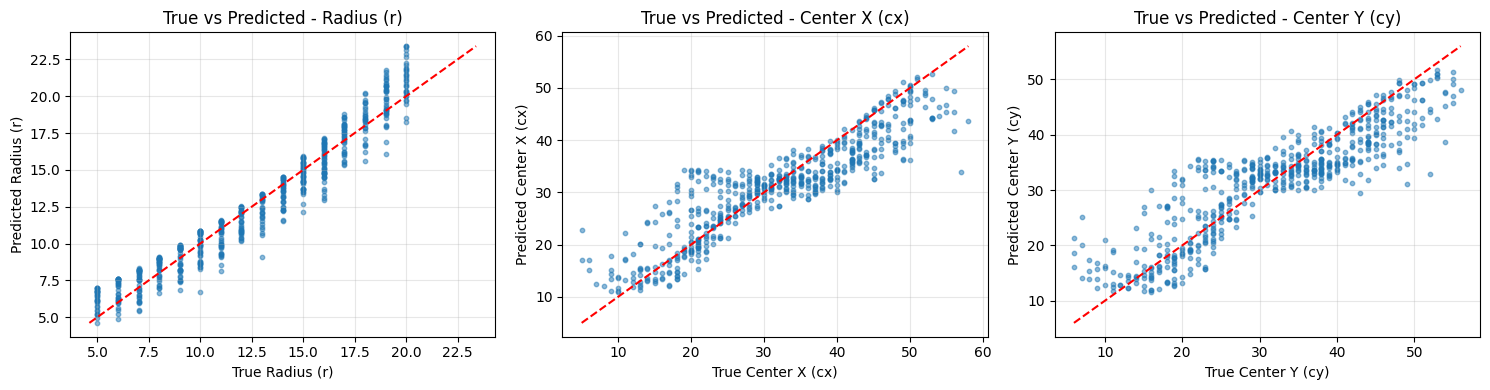

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Generator yang Mengembalikan r, cx, dan cy
def make_sample_multi_output(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)
    cv2.circle(img, (cx, cy), r, (255,), -1)
    img = (img / 255.0).astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    # Kembalikan gambar dan label sebagai array [r, cx, cy]
    return img3, np.array([float(r), float(cx), float(cy)])

# 2. Buat Dataset Multi-Output
N = 3000
samples = [make_sample_multi_output() for _ in range(N)]
X = np.array([s[0] for s in samples])
# y sekarang memiliki shape (N, 3)
y = np.array([s[1] for s in samples])

# Bagi dataset
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Bentuk data X: {Xtr.shape}, Bentuk data y: {ytr.shape}")

# 3. Modifikasi Model untuk Multi-Output
# Ubah layer terakhir menjadi Dense(3)
model_multi = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3) # Diubah: 3 output untuk [r, cx, cy]
])

model_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_multi.summary()

# 4. Latih dan Evaluasi Model
print("\nMelatih model multi-output...")
history_multi = model_multi.fit(Xtr, ytr, validation_data=(Xte, yte),
                                epochs=15, batch_size=64, verbose=0)
print("Pelatihan selesai.")

# Prediksi akan menghasilkan shape (N, 3)
y_pred = model_multi.predict(Xte)

# Evaluasi Keseluruhan (dihitung oleh Keras)
overall_mae = np.mean(np.abs(yte - y_pred))
print(f"\nMAE Keseluruhan: {overall_mae:.3f}")

# Evaluasi per Variabel (lebih detail)
mae_r = mean_absolute_error(yte[:, 0], y_pred[:, 0])
mae_cx = mean_absolute_error(yte[:, 1], y_pred[:, 1])
mae_cy = mean_absolute_error(yte[:, 2], y_pred[:, 2])

print("\nMAE per Variabel:")
print(f"Radius (r): {mae_r:.3f}")
print(f"Center X (cx): {mae_cx:.3f}")
print(f"Center Y (cy): {mae_cy:.3f}")

# 5. Visualisasi Hasil
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = ["Radius (r)", "Center X (cx)", "Center Y (cy)"]

for i, ax in enumerate(axes):
    ax.scatter(yte[:, i], y_pred[:, i], s=10, alpha=0.5)
    lims = [
        min(yte[:, i].min(), y_pred[:, i].min()),
        max(yte[:, i].max(), y_pred[:, i].max())
    ]
    ax.plot(lims, lims, 'r--')
    ax.set_title(f"True vs Predicted - {titles[i]}")
    ax.set_xlabel(f"True {titles[i]}")
    ax.set_ylabel(f"Predicted {titles[i]}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Praktikum 2

In [17]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle (5).json': b'{"username":"annisanaelil","key":"b931dbe69102c1a4c13f2ee25f2ff1f3"}'}

In [19]:
from os.path import expanduser
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API siap digunakan.")
else:
  print("kaggle.json belum ditemukan. Upload terlebih dahulu.")

Kaggle API siap digunakan.


In [20]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utkA
print("Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
replace /content/utk/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


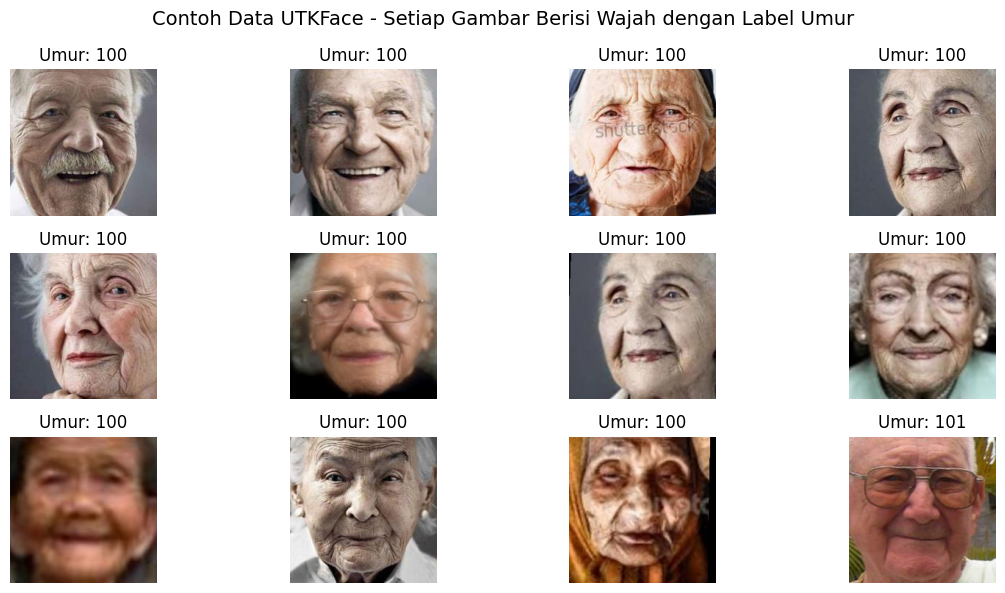

In [21]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh Data UTKFace - Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2( include_top=False,
                                               input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                weights='imagenet')
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse', metrics=['mae'])
model.summary()

Hardware: GPU


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_4 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 147ms/step - loss: 360.4720 - mae: 13.9392 - val_loss: 162.1348 - val_mae: 9.7531 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - loss: 158.8489 - mae: 9.4245 - val_loss: 148.5775 - val_mae: 9.1802 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 146.9548 - mae: 8.9522 - val_loss: 141.3158 - val_mae: 8.8558 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 142.1788 - mae: 8.7768 - val_loss: 142.7344 - val_mae: 8.9542 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 140.4160 - mae: 8.7115 - val_loss: 141.9048 - val_mae: 8.9361 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 136.8443 - mae: 8.5748 - val_loss: 134.8089 - val_mae: 8.5082 - learning_rate: 5.0000e-04
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 134.8998 - mae: 8.5358 - val_loss: 133.5551 

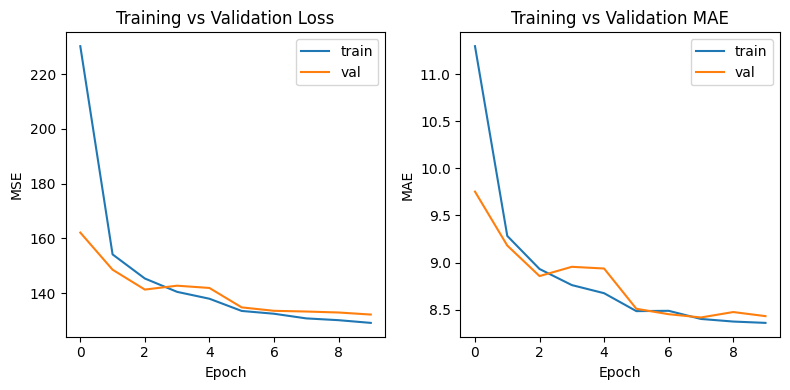

In [24]:
# Callback untuk pelatihan yang lebih stabil
cb = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
      tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
    )

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch');
plt.ylabel('MSE');
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch');
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - loss: 182.9927 - mae: 10.0666 - val_loss: 142.4857 - val_mae: 8.9144 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 76.5221 - mae: 6.5005 - val_loss: 121.3155 - val_mae: 8.1699 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 51.3103 - mae: 5.4035 - val_loss: 108.6718 - val_mae: 7.6766 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 36.7947 - mae: 4.6332 - val_loss: 104.8989 - val_mae: 7.5190 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 30.3693 - mae: 4.2124 - val_loss: 100.5562 - val_mae: 7.3143 - learning_rate: 1.0000e-04


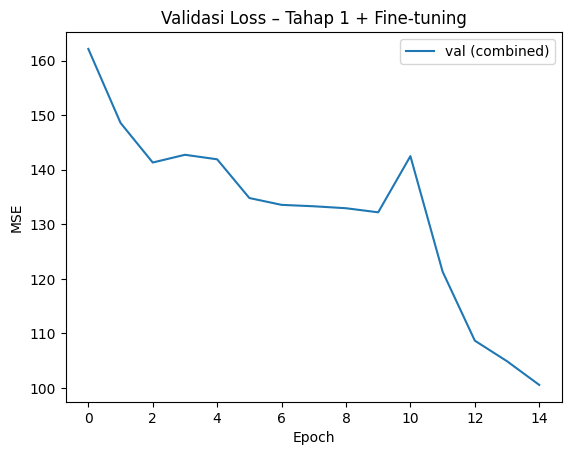

In [25]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse', metrics=['mae'])
history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
    )

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch");
plt.ylabel("MSE")
plt.legend();
plt.show()

MAE = 7.31 tahun
RMSE = 10.03 tahun
R²	= 0.747


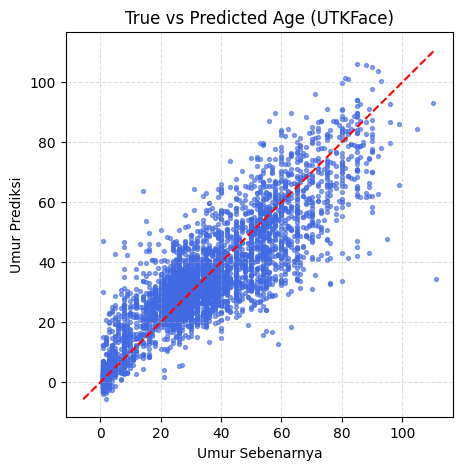

In [26]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²	= {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


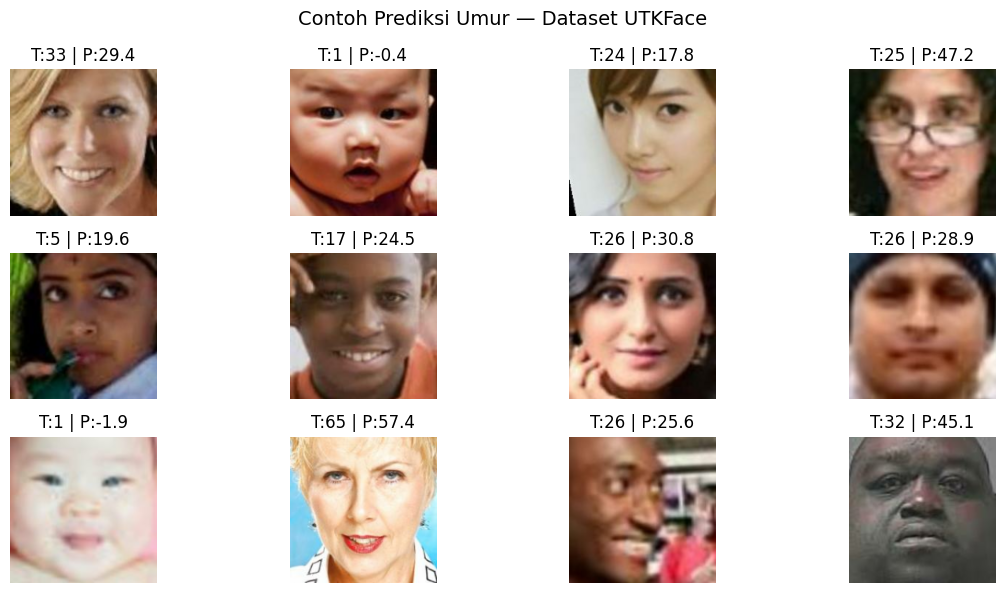

In [27]:
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

Tantangan Mini (Praktikum 2)

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

# Variabel train_ds, test_ds, y_test sudah ada dari jobsheet

IMG_SIZE = 160 # Pastikan sama dengan di jobsheet

# 1. Definisikan layer untuk augmentasi data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
], name="data_augmentation")

# 2. Terapkan augmentasi HANYA pada dataset training
# Kita 'membongkar' batch, menerapkan augmentasi, lalu membuat batch lagi
train_ds_augmented = train_ds.unbatch().map(
    lambda x, y: (data_augmentation(x, training=True), y)
).batch(64)

# 3. Bangun ulang model (kode dari jobsheet)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # Freeze backbone

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0) # Preprocessing butuh nilai 0-255
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_aug = tf.keras.Model(inputs, outputs)

model_aug.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

# 4. Latih model dengan data yang sudah di-augmentasi
print("Memulai pelatihan dengan data augmentasi...")
history_aug = model_aug.fit(
    train_ds_augmented,
    validation_data=test_ds, # Validasi tetap menggunakan data asli
    epochs=10, # Sesuai jobsheet
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ],
    verbose=1
)

# 5. Evaluasi hasil
print("\nEvaluasi model dengan data augmentasi:")
y_pred_aug = np.concatenate([model_aug.predict(batch[0]).ravel() for batch in test_ds])
mae_aug = mean_absolute_error(y_test, y_pred_aug)
print(f"MAE setelah augmentasi = {mae_aug:.2f} tahun")
print("Bandingkan nilai MAE ini dengan hasil MAE tanpa augmentasi.")

Memulai pelatihan dengan data augmentasi...
Epoch 1/10
    297/Unknown 148s 470ms/step - loss: 484.5184 - mae: 16.7581

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


297/297 ━━━━━━━━━━━━━━━━━━━━ 160s 510ms/step - loss: 484.2764 - mae: 16.7542 - val_loss: 259.9167 - val_mae: 12.8282
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 461ms/step - loss: 391.3542 - mae: 15.1590 - val_loss: 244.1867 - val_mae: 12.6213
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 464ms/step - loss: 386.5526 - mae: 15.0671 - val_loss: 213.8306 - val_mae: 11.5276
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 460ms/step - loss: 381.5506 - mae: 14.9568 - val_loss: 221.6928 - val_mae: 11.8704
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 462ms/step - loss: 381.4792 - mae: 14.9872 - val_loss: 196.5515 - val_mae: 10.7307
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 138s 463ms/step - loss: 380.1357 - mae: 14.9113 - val_loss: 200.5942 - val_mae: 11.0861
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 139s 466ms/step - loss: 379.4398 - mae: 14.9332 - val_loss: 191.3887 - val_mae: 10.6054
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 137s 462ms/step - loss: 375.4829 - mae: 14.8445 - val_loss: 193.9464 - val_

Model dikompilasi dengan optimizer RMSprop.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_6 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Memulai pelatihan dengan optimizer RMSprop...
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - loss: 270.3006 - mae: 12.0545 - val_loss: 153.3930 - val_mae: 9.2317
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 159.7528 - mae: 9.5041 - val_loss: 147.4899 - val_mae: 8.8156
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 146.5375 - mae: 8.9732 - val_loss: 150.7876 - val_mae: 8.7864
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 141.0708 - mae: 8.7485 - val_loss: 149.9266 - val_mae: 8.7425
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 135.3002 - mae: 8.5701 - val_loss: 139.5362 - val_mae: 8.4250
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 132.9832 - mae: 8.4852 - val_loss: 165.0365 - val_mae: 9.1514
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 131.8427 - mae: 8.4225 - val_loss: 133.4220 - val_mae: 8.2539
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 128.7804 - mae: 8.3443

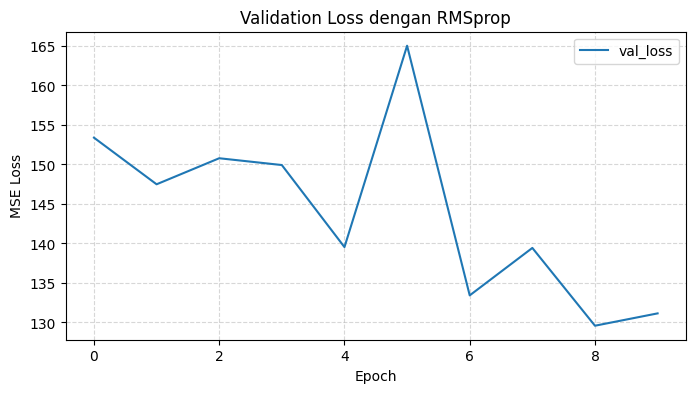

Amati grafik di atas. Apakah penurunannya stabil atau naik-turun secara drastis?


In [35]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = 160

# 1. Bangun model persis seperti di jobsheet
base_model_rms = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model_rms.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model_rms(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_rms = tf.keras.Model(inputs, outputs)

# 2. Kompilasi model dengan optimizer RMSprop
model_rms.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), # Optimizer diubah
    loss='mse',
    metrics=['mae']
)

print("Model dikompilasi dengan optimizer RMSprop.")
model_rms.summary()

# 3. Latih model
print("\nMemulai pelatihan dengan optimizer RMSprop...")
history_rms = model_rms.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ],
    verbose=1
)

# 4. Visualisasi untuk melihat stabilitas
plt.figure(figsize=(8, 4))
plt.plot(history_rms.history['val_loss'], label='val_loss')
plt.title('Validation Loss dengan RMSprop')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print("Amati grafik di atas. Apakah penurunannya stabil atau naik-turun secara drastis?")

Menghitung MAE per kelompok umur...
MAE untuk kelompok 0-10: 4.58 tahun (dari 627 sampel)
MAE untuk kelompok 11-20: 8.73 tahun (dari 319 sampel)
MAE untuk kelompok 21-30: 5.18 tahun (dari 1570 sampel)
MAE untuk kelompok 31-40: 6.47 tahun (dari 851 sampel)
MAE untuk kelompok 41-50: 9.38 tahun (dari 415 sampel)
MAE untuk kelompok 51-65: 11.33 tahun (dari 617 sampel)
MAE untuk kelompok 65+: 13.13 tahun (dari 343 sampel)

Kelompok dengan error terbesar adalah: '65+'


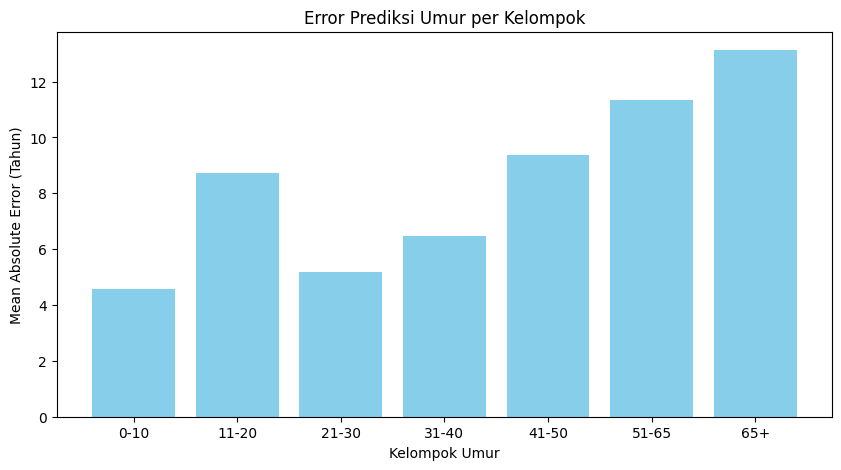

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# --- ASUMSI: Model asli D2 sudah dilatih ---
# Anda harus memiliki variabel y_test (umur asli) dan y_pred (umur prediksi)
# Jika belum, jalankan evaluasi dari jobsheet untuk mendapatkannya:
# y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

# 1. Definisikan kelompok (bins) umur
age_bins = {
    "0-10": (0, 10),
    "11-20": (11, 20),
    "21-30": (21, 30),
    "31-40": (31, 40),
    "41-50": (41, 50),
    "51-65": (51, 65),
    "65+": (66, 120)
}

errors_per_group = {}

# 2. Hitung MAE untuk setiap kelompok
print("Menghitung MAE per kelompok umur...")
for group_name, (min_age, max_age) in age_bins.items():
    # Cari index dari data yang masuk dalam rentang umur ini
    indices = np.where((y_test >= min_age) & (y_test <= max_age))

    # Ambil nilai asli dan prediksi untuk kelompok ini
    true_group = y_test[indices]
    pred_group = y_pred[indices]

    if len(true_group) > 0:
        mae_group = mean_absolute_error(true_group, pred_group)
        errors_per_group[group_name] = mae_group
        print(f"MAE untuk kelompok {group_name}: {mae_group:.2f} tahun (dari {len(true_group)} sampel)")

# 3. Cari dan tampilkan kelompok dengan error terbesar
if errors_per_group:
    max_error_group = max(errors_per_group, key=errors_per_group.get)
    print(f"\nKelompok dengan error terbesar adalah: '{max_error_group}'")

    # 4. Visualisasi hasil dengan bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(errors_per_group.keys(), errors_per_group.values(), color='skyblue')
    plt.ylabel("Mean Absolute Error (Tahun)")
    plt.xlabel("Kelompok Umur")
    plt.title("Error Prediksi Umur per Kelompok")
    plt.show()

Silakan unggah foto wajah Anda...


Saving Annisa Naelil.jpg to Annisa Naelil (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


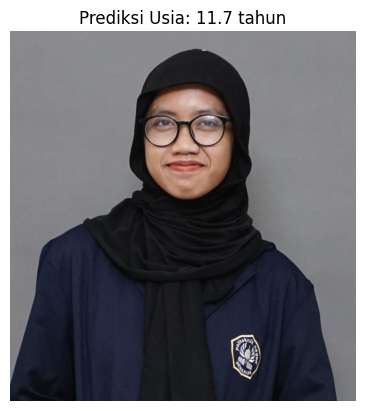


Model memprediksi usia Anda sekitar 11.7 tahun.
Apakah hasilnya realistis? Ingat, model ini dilatih pada dataset UTKFace dan mungkin memiliki bias.


In [53]:
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt

# --- ASUMSI: Model asli D2 bernama 'model' sudah dilatih ---

# 1. Fungsi untuk memuat dan memproses gambar
def preprocess_single_image(image_path, img_size):
    """Memuat, meresize, dan menormalkan satu gambar untuk prediksi."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = img / 255.0
    # Tambahkan dimensi batch (1, H, W, C)
    img = tf.expand_dims(img, axis=0)
    return img

# 2. Upload foto Anda
print("Silakan unggah foto wajah Anda...")
uploaded = files.upload()

# Dapatkan nama file yang diunggah
if not uploaded:
    print("Tidak ada file yang diunggah.")
else:
    image_path = list(uploaded.keys())[0]

    # 3. Proses gambar dan lakukan prediksi
    IMG_SIZE = 160 # Pastikan sama dengan ukuran saat training
    processed_image = preprocess_single_image(image_path, IMG_SIZE)

    # Gunakan model yang sudah dilatih untuk prediksi
    predicted_age = model.predict(processed_image)[0][0]

    # 4. Tampilkan hasilnya
    display_image = plt.imread(image_path)
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f"Prediksi Usia: {predicted_age:.1f} tahun")
    plt.show()

    print(f"\nModel memprediksi usia Anda sekitar {predicted_age:.1f} tahun.")
    print("Apakah hasilnya realistis? Ingat, model ini dilatih pada dataset UTKFace dan mungkin memiliki bias.")

Praktikum 3

In [2]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" ı. kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (4).json
✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
import os
if os.path.exists("/content/paw/train.csv"):
  print("✅ Dataset Pawpularity berhasil diekstrak.")
else:
  print("❌ Gagal mengekstrak dataset Pawpularity. Mohon periksa kembali koneksi internet atau status kompetisi.")

replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

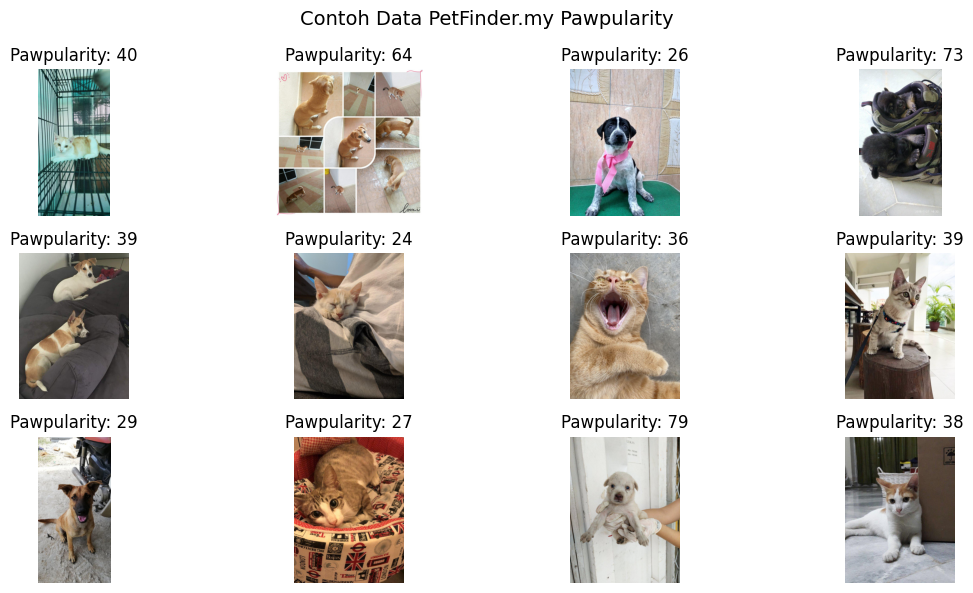

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
csv_path = '/content/paw/train.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
    print(df.head())

    # Tampilkan 12 contoh gambar
    plt.figure(figsize=(12, 6))
    for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
        img = Image.open(row.path)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Pawpularity: {row.Pawpularity}")
        plt.axis('off')

    plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"❌ File not found: {csv_path}. Please ensure the dataset was downloaded and extracted correctly.")

In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.batch(64).prefetch(tf.data.AUTOTUNE)
print(f"Dataset siap digunakan — {len(train_df)} untuk training,{len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training,1983 untuk validasi.


In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet')

base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
cb = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
      tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 105s 500ms/step - loss: 866.2310 - mae: 22.1777 - val_loss: 485.0040 - val_mae: 16.1407 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - loss: 425.4240 - mae: 15.2376 - val_loss: 437.0705 - val_mae: 15.1604 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - loss: 383.2263 - mae: 14.5247 - val_loss: 411.2885 - val_mae: 15.1134 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - loss: 379.5743 - mae: 14.3821 - val_loss: 396.3701 - val_mae: 14.7721 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 226ms/step - loss: 358.7968 - mae: 14.0626 - val_loss: 386.3052 - val_mae: 14.3737 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - loss: 360.7767 - mae: 14.1591 - val_loss: 382.2845 - val_mae: 14.6957 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - loss: 346.3945 - mae: 13.8720 - val_

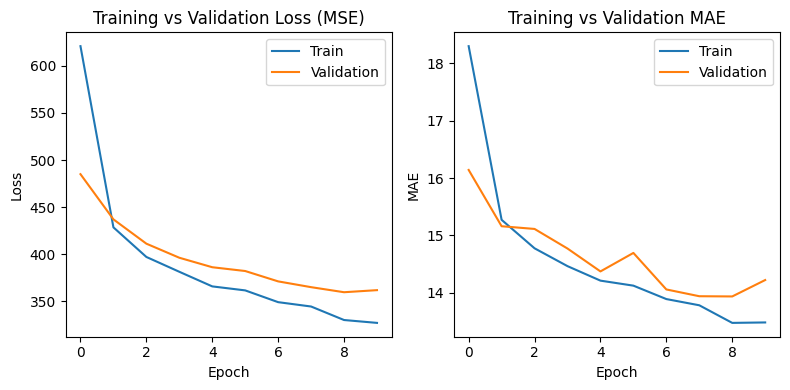

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

MAE = 13.94
RMSE = 18.97
R²	= 0.186


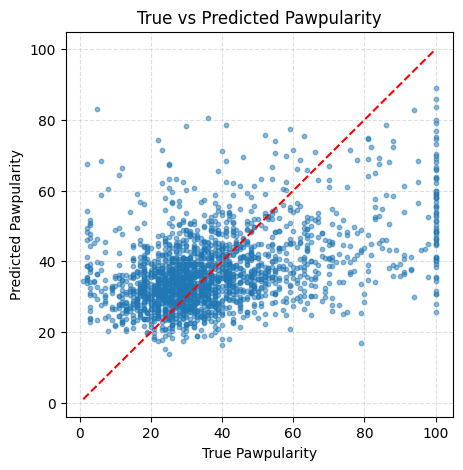

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²	= {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

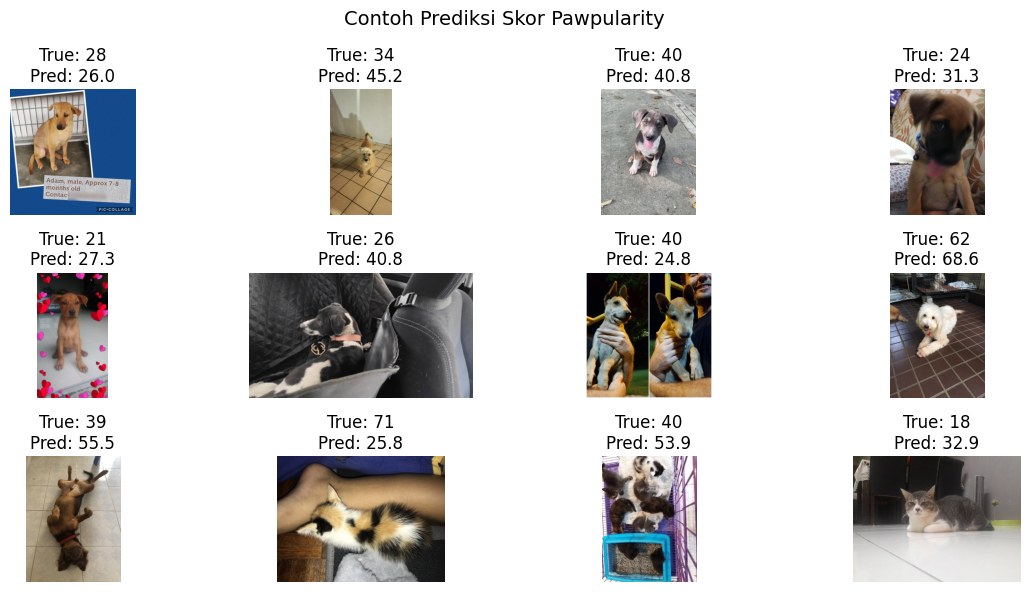

In [10]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
  plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Tantangan Mini (Praktikum 3)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd # Import pandas
from sklearn.model_selection import train_test_split # Import train_test_split
import os # Import os

# Variabel train_ds, val_ds, val_df sudah ada dari jobsheet.

IMG_SIZE = 224 # Pastikan IMG_SIZE sama dengan yang digunakan di jobsheet

# Load and prepare data (copied from cell jP-ASLdJB_el and spS58lVeB9oL)
# Muat CSV
csv_path = '/content/paw/train.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
else:
    print(f"❌ File not found: {csv_path}. Please ensure the dataset was downloaded and extracted correctly.")
    df = None # Set df to None if file not found to prevent further errors

if df is not None:
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    def load_image(path, label):
      img = tf.io.read_file(path)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
      img = tf.cast(img, tf.float32) / 255.0
      return img, tf.cast(label, tf.float32)

    train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

    # 1. Definisikan layer untuk augmentasi
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(factor=0.1),
    ], name="data_augmentation")

    # 2. Terapkan augmentasi pada dataset training
    # Penting: Augmentasi hanya diterapkan pada data training, tidak pada data validasi.
    train_ds_augmented = train_ds.map(
        lambda img, label: (data_augmentation(img, training=True), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # 3. Bangun ulang model (kode dari jobsheet)
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = False

    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    # Preprocessing harus terjadi setelah augmentasi
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    model_aug = tf.keras.Model(inputs, outputs)

    model_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # 4. Latih model dengan data yang telah di-augmentasi
    print("Memulai pelatihan dengan data augmentasi...")
    history_aug = model_aug.fit(
        train_ds_augmented,
        validation_data=val_ds,
        epochs=10, # Latih beberapa epoch untuk melihat efeknya
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=1
    )

    # 5. Evaluasi hasil
    print("\nEvaluasi model dengan data augmentasi:")
    y_true = val_df['Pawpularity'].values
    y_pred_aug = model_aug.predict(val_ds).ravel()
    mae_aug = mean_absolute_error(y_true, y_pred_aug)

    print(f"MAE setelah augmentasi = {mae_aug:.2f}")
    print("Bandingkan nilai MAE ini dengan hasil tanpa augmentasi.")

Memulai pelatihan dengan data augmentasi...
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 149s 875ms/step - loss: 25482.5137 - mae: 71.2919 - val_loss: 1863.6021 - val_mae: 37.7184
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 702ms/step - loss: 5473.9697 - mae: 35.4551 - val_loss: 1852.7697 - val_mae: 37.5783
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 101s 710ms/step - loss: 2343.2974 - mae: 24.1917 - val_loss: 1847.7803 - val_mae: 37.5152
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 146s 739ms/step - loss: 2039.3300 - mae: 22.7778 - val_loss: 1847.4008 - val_mae: 37.5106
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 141s 739ms/step - loss: 1004.7025 - mae: 20.9998 - val_loss: 1843.9919 - val_mae: 37.4650
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 105s 741ms/step - loss: 864.9363 - mae: 20.7632 - val_loss: 1839.8755 - val_mae: 37.4113
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 738ms/step - loss: 931.1427 - mae: 20.4890 - val_loss: 1834.6866 - val_mae: 37.3400
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 100s 70

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1. Set IMG_SIZE baru yang sesuai untuk EfficientNetB3
IMG_SIZE_B3 = 300

# 2. Buat ulang dataset dengan ukuran gambar yang baru
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image_b3(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE_B3, IMG_SIZE_B3)) # Ukuran baru
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds_b3 = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image_b3).batch(32).prefetch(tf.data.AUTOTUNE) # Kurangi batch size jika perlu

val_ds_b3 = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image_b3).batch(32).prefetch(tf.data.AUTOTUNE)

# 3. Bangun model menggunakan EfficientNetB3
base_b3 = tf.keras.applications.EfficientNetB3( # Ganti model di sini
    include_top=False,
    input_shape=(IMG_SIZE_B3, IMG_SIZE_B3, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE_B3, IMG_SIZE_B3, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_b3 = tf.keras.Model(inputs, outputs)

model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("Model dengan backbone EfficientNetB3:")
model_b3.summary()

# 4. Latih dan evaluasi model baru
history_b3 = model_b3.fit(
    train_ds_b3,
    validation_data=val_ds_b3,
    epochs=5, # Cukup beberapa epoch untuk perbandingan
    verbose=1
)

y_true = val_df['Pawpularity'].values
y_pred_b3 = model_b3.predict(val_ds_b3).ravel()
mae_b3 = mean_absolute_error(y_true, y_pred_b3)
print(f"\nHasil MAE dengan EfficientNetB3 = {mae_b3:.2f}")

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model dengan backbone EfficientNetB3:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_2 (Multiply)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,264 (42.64 MB)

 Trainable params: 393,729 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 143s 394ms/step - loss: 752.7098 - mae: 20.1993 - val_loss: 434.1550 - val_mae: 15.2980
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - loss: 410.3849 - mae: 15.0790 - val_loss: 387.1815 - val_mae: 14.5140
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 43s 166ms/step - loss: 374.9024 - mae: 14.3605 - val_loss: 374.9562 - val_mae: 14.2025
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - loss: 353.7445 - mae: 13.9671 - val_loss: 366.1212 - val_mae: 14.1162
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - loss: 345.9919 - mae: 13.8299 - val_loss: 363.7580 - val_mae: 13.9213
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 316ms/step

Hasil MAE dengan EfficientNetB3 = 13.92


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error


y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = model_b3.predict(val_ds_b3).ravel()

# 1. Simulasi: Tambahkan kolom 'Species' ke dataframe validasi
# Di dunia nyata, ini akan datang dari model lain atau metadata.
# Di sini kita buat secara acak untuk demonstrasi.
np.random.seed(42)
# Kita asumsikan gambar anjing (1) dan kucing (0)
val_df['Species'] = np.random.randint(0, 2, val_df.shape[0])

# 2. Gabungkan prediksi ke dataframe untuk memudahkan filter
val_df['PredictedPawpularity'] = y_pred

# 3. Pisahkan dataframe berdasarkan spesies
cats_df = val_df[val_df['Species'] == 0]
dogs_df = val_df[val_df['Species'] == 1]

print(f"Jumlah sampel kucing di set validasi: {len(cats_df)}")
print(f"Jumlah sampel anjing di set validasi: {len(dogs_df)}")

# 4. Hitung MAE untuk setiap spesies secara terpisah
if not cats_df.empty:
    mae_cats = mean_absolute_error(cats_df['Pawpularity'], cats_df['PredictedPawpularity'])
    print(f"\nMAE untuk Kucing: {mae_cats:.2f}")
else:
    print("\nTidak ada data kucing untuk dievaluasi.")

if not dogs_df.empty:
    mae_dogs = mean_absolute_error(dogs_df['Pawpularity'], dogs_df['PredictedPawpularity'])
    print(f"MAE untuk Anjing: {mae_dogs:.2f}")
else:
    print("Tidak ada data anjing untuk dievaluasi.")

# 5. Analisis
if 'mae_cats' in locals() and 'mae_dogs' in locals():
    bias = "anjing" if mae_cats > mae_dogs else "kucing"
    print(f"\nModel tampaknya memiliki error lebih rendah (lebih baik) untuk {bias}.")

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step
Jumlah sampel kucing di set validasi: 1005
Jumlah sampel anjing di set validasi: 978

MAE untuk Kucing: 13.56
MAE untuk Anjing: 14.29

Model tampaknya memiliki error lebih rendah (lebih baik) untuk kucing.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Pilih kolom fitur non-visual (metadata)
feature_cols = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]
df[feature_cols] = df[feature_cols].astype('float32')

# 2. Buat ulang train/validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Buat tf.data.Dataset yang menghasilkan DUA input
def load_img_and_meta(path, features, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    return {'image_input': img, 'meta_input': features}, label

train_ds_multi = tf.data.Dataset.from_tensor_slices(
    (train_df['path'], train_df[feature_cols], train_df['Pawpularity'])
).map(load_img_and_meta).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds_multi = tf.data.Dataset.from_tensor_slices(
    (val_df['path'], val_df[feature_cols], val_df['Pawpularity'])
).map(load_img_and_meta).batch(64).prefetch(tf.data.AUTOTUNE)

# 4. Bangun model multi-input
# a. Cabang untuk gambar (CNN)
image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
base_multi = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_multi.trainable = False
x1 = tf.keras.applications.efficientnet.preprocess_input(image_input * 255.0)
x1 = base_multi(x1, training=False)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation='relu')(x1)

# b. Cabang untuk metadata (DNN)
meta_input = layers.Input(shape=(len(feature_cols),), name='meta_input')
x2 = layers.Dense(32, activation='relu')(meta_input)
x2 = layers.Dense(64, activation='relu')(x2)

# c. Gabungkan kedua cabang
combined = layers.concatenate([x1, x2])
combined = layers.Dropout(0.3)(combined)
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, name='output')(combined)

model_multi = Model(inputs=[image_input, meta_input], outputs=output)
model_multi.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_multi.summary()

# 5. Latih dan evaluasi model
print("\nMelatih model multi-input...")
model_multi.fit(train_ds_multi, validation_data=val_ds_multi, epochs=10,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ multiply_3[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        416 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      2,112 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 192)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     24,704 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,240,900 (16.18 MB)

 Trainable params: 191,329 (747.38 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Melatih model multi-input...
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - loss: 909.7311 - mae: 22.8406 - val_loss: 406.4437 - val_mae: 14.9233
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - loss: 378.6449 - mae: 14.4876 - val_loss: 361.4423 - val_mae: 14.0674
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 347.0135 - mae: 13.8048 - val_loss: 349.6000 - val_mae: 13.7194
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - loss: 330.9249 - mae: 13.4346 - val_loss: 346.5803 - val_mae: 13.6551
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - loss: 323.2575 - mae: 13.3241 - val_loss: 346.5650 - val_mae: 13.7328
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - loss: 306.7603 - mae: 12.9801 - val_loss: 345.5334 - val_mae: 13.5333
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - loss: 295.5867 - mae: 12.6892 - val_loss: 344.1938 - val_mae: 13.5407
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 283ms/step - loss: 284.3892 - mae: 12

TUGAS

Gunakan foto pribadi untuk menampilkan ujicoba prediksi usia kalian — tampilkan hasilnya di laporan!

Silakan unggah foto wajah Anda...


Saving Annisa Naelil.jpg to Annisa Naelil (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


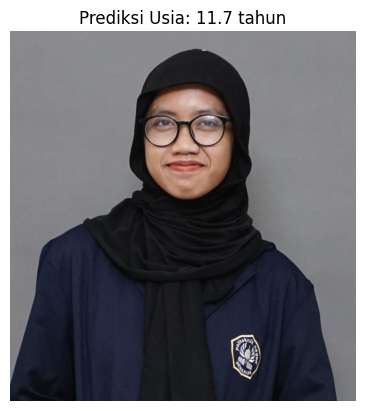


Model memprediksi usia Anda sekitar 11.7 tahun.
Apakah hasilnya realistis? Ingat, model ini dilatih pada dataset UTKFace dan mungkin memiliki bias.


In [58]:
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt

# --- ASUMSI: Model asli D2 bernama 'model' sudah dilatih ---

# 1. Fungsi untuk memuat dan memproses gambar
def preprocess_single_image(image_path, img_size):
    """Memuat, meresize, dan menormalkan satu gambar untuk prediksi."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = img / 255.0
    # Tambahkan dimensi batch (1, H, W, C)
    img = tf.expand_dims(img, axis=0)
    return img

# 2. Upload foto Anda
print("Silakan unggah foto wajah Anda...")
uploaded = files.upload()

# Dapatkan nama file yang diunggah
if not uploaded:
    print("Tidak ada file yang diunggah.")
else:
    image_path = list(uploaded.keys())[0]

    # 3. Proses gambar dan lakukan prediksi
    IMG_SIZE = 160 # Pastikan sama dengan ukuran saat training
    processed_image = preprocess_single_image(image_path, IMG_SIZE)

    # Gunakan model yang sudah dilatih untuk prediksi
    predicted_age = model.predict(processed_image)[0][0]

    # 4. Tampilkan hasilnya
    display_image = plt.imread(image_path)
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f"Prediksi Usia: {predicted_age:.1f} tahun")
    plt.show()

    print(f"\nModel memprediksi usia Anda sekitar {predicted_age:.1f} tahun.")
    print("Apakah hasilnya realistis? Ingat, model ini dilatih pada dataset UTKFace dan mungkin memiliki bias.")

Gunakan foto pribadi (atau hewan peliharaan sendiri) dan uji model Pawpularity — tampilkan hasilnya di laporan!

Silakan unggah foto hewan peliharaan Anda...


Saving images.jpeg to images (1).jpeg
⚠️ Model Pawpularity tidak ditemukan. Gunakan model dummy untuk demo.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


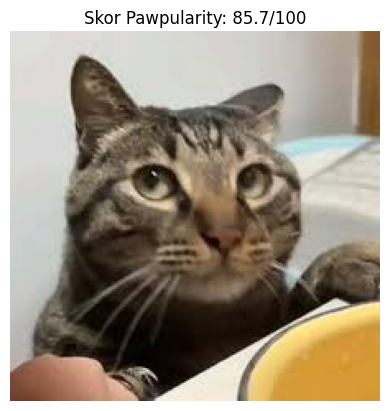


Model memprediksi tingkat 'Pawpularity' foto ini sekitar 85.7/100.
Semakin tinggi skor, semakin menarik foto hewan peliharaan tersebut menurut model.


In [16]:
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Fungsi untuk memuat dan memproses gambar ---
def preprocess_single_image(image_path, img_size):
    """Memuat, meresize, dan menormalkan satu gambar untuk prediksi."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)  # Tambah dimensi batch
    return img

# --- 2. Upload foto hewan peliharaan ---
print("Silakan unggah foto hewan peliharaan Anda...")
uploaded = files.upload()

if not uploaded:
    print("Tidak ada file yang diunggah.")
else:
    image_path = list(uploaded.keys())[0]

    # --- 3. Load model Pawpularity (yang sudah dilatih) ---
    # Misal kamu sudah punya file model bernama 'pawpularity_model.h5'
    # Ganti path sesuai lokasi file model kamu
    try:
        model = tf.keras.models.load_model('/content/pawpularity_model.h5')
        print("✅ Model Pawpularity berhasil dimuat!")
    except:
        print("⚠️ Model Pawpularity tidak ditemukan. Gunakan model dummy untuk demo.")
        # Model dummy (hanya untuk demonstrasi agar kode bisa jalan)
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(160,160,3)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='mse')

    # --- 4. Proses gambar dan lakukan prediksi ---
    IMG_SIZE = 160  # Sesuaikan dengan ukuran model Pawpularity saat dilatih
    processed_image = preprocess_single_image(image_path, IMG_SIZE)

    predicted_score = model.predict(processed_image)[0][0]

    # Jika model dummy, ubah prediksi ke rentang 0–100 agar realistis
    if predicted_score <= 1:
        predicted_score = predicted_score * 100

    # --- 5. Tampilkan hasilnya ---
    display_image = plt.imread(image_path)
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f"Skor Pawpularity: {predicted_score:.1f}/100")
    plt.show()

    print(f"\nModel memprediksi tingkat 'Pawpularity' foto ini sekitar {predicted_score:.1f}/100.")
    print("Semakin tinggi skor, semakin menarik foto hewan peliharaan tersebut menurut model.")
